In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
import numpy as np

import xgboost as xgb

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

from sklearn.linear_model import LassoCV, Lasso

from math import sqrt

import seaborn as sns


np.set_printoptions(suppress=True, precision=4)

%matplotlib inline

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/abulbasar/data/master/startups.csv")
df.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
R&D Spend          48 non-null float64
Administration     50 non-null float64
Marketing Spend    47 non-null float64
State              50 non-null object
Profit             50 non-null float64
dtypes: float64(4), object(1)
memory usage: 2.0+ KB


There are 50 observations and 5 columns. 4 columns - R&D Spend, Administration and Marketing Spend, and Profile are numeric and one is categorical - State. There is 2 null values in columns R&D Spend feature and and 3 in Marketing Spend. 

Replace the null values with median for respective state. 

In [4]:
df_null_idx = df[df.isnull().sum(axis = 1) > 0].index
df.iloc[df_null_idx]

,R&D Spend,Administration,Marketing Spend,State,Profit
19,86419.70,153514.11,NaN,New York,122776.86
47,NaN,135426.92,NaN,California,42559.73
48,542.05,51743.15,NaN,New York,35673.41
49,NaN,116983.80,45173.06,California,14681.40


In [5]:
median_values = df.groupby("State")[["R&D Spend", "Marketing Spend"]].median()
median_values

,R&D Spend,Marketing Spend
State,,
California,64664.710,186014.36
Florida,74661.715,253176.18
New York,77044.010,261776.23


In [6]:
df["R&D Spend"] = df.apply(lambda row: median_values.loc[row["State"], "R&D Spend"]  if np.isnan(row["R&D Spend"]) else row["R&D Spend"], axis = 1 )
df["Marketing Spend"] = df.apply(lambda row: median_values.loc[row["State"], "Marketing Spend"]  if np.isnan(row["Marketing Spend"]) else row["Marketing Spend"], axis = 1 )
df.iloc[df_null_idx]

,R&D Spend,Administration,Marketing Spend,State,Profit
19,86419.70,153514.11,261776.23,New York,122776.86
47,64664.71,135426.92,186014.36,California,42559.73
48,542.05,51743.15,261776.23,New York,35673.41
49,64664.71,116983.80,45173.06,California,14681.40


Let's see the distribution of the Profit using a histogram plot and see if there is any outliers in the data using bosplot.

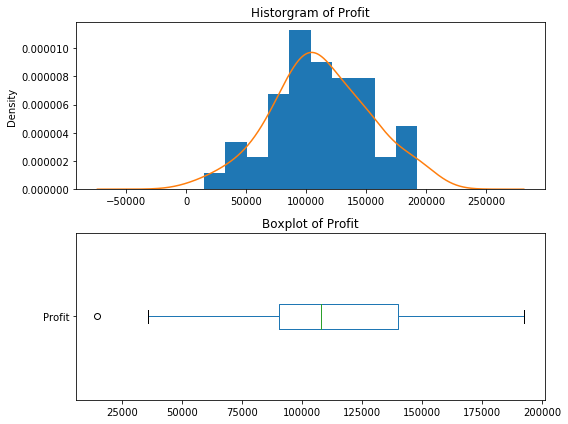

In [7]:
plt.figure(figsize = (8, 6))
plt.subplot(2, 1, 1)
df.Profit.plot.hist(bins = 10, normed = True)
df.Profit.plot.kde(title = "Historgram of Profit")

plt.subplot(2, 1, 2)
df.Profit.plot.box(vert = False, title = "Boxplot of Profit")

plt.tight_layout()

Profit has one outlier. We can try to take log scale to remove the outlier value before doing any prediction. But for now, let ignore the outlier.

Let's plot association between each pair of columns. 

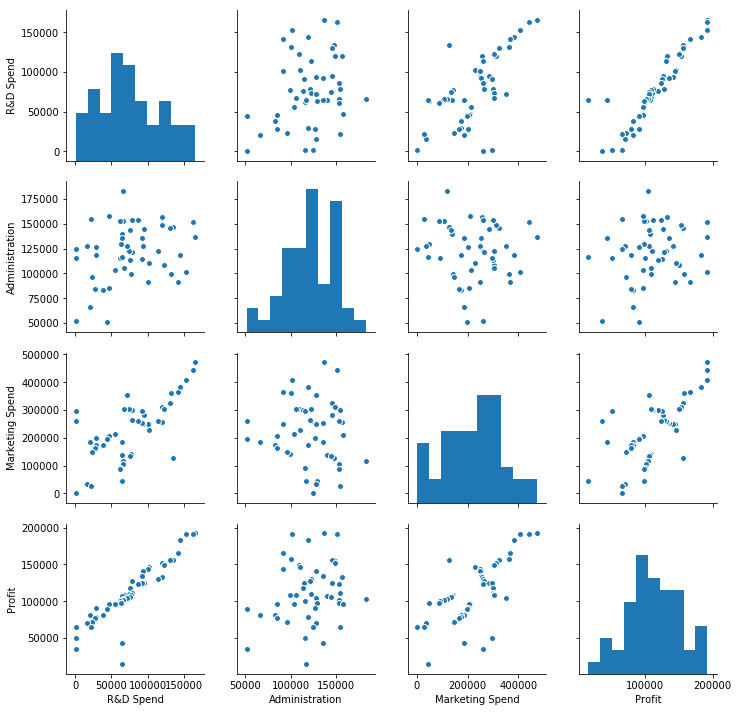

In [8]:
sns.pairplot(df)

Displays only the numeric column. Let's how the avg Profit plays for each State.

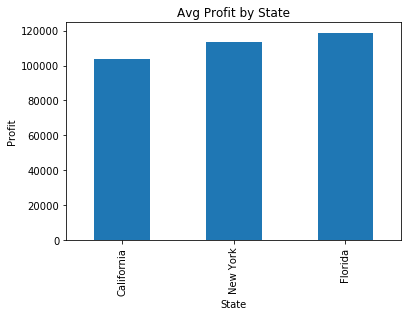

In [9]:
df.groupby("State").Profit.mean().sort_values().plot.bar(title = "Avg Profit by State")
plt.xlabel("State")
plt.ylabel("Profit")

Avg Profit is highest in state of Florida and least in California.

Let's create the y vector containing the outcome column.

In [10]:
y = df.Profit.values
y

array([ 192261.83,  191792.06,  191050.39,  182901.99,  166187.94,
        156991.12,  156122.51,  155752.6 ,  152211.77,  149759.96,
        146121.95,  144259.4 ,  141585.52,  134307.35,  132602.65,
        129917.04,  126992.93,  125370.37,  124266.9 ,  122776.86,
        118474.03,  111313.02,  110352.25,  108733.99,  108552.04,
        107404.34,  105733.54,  105008.31,  103282.38,  101004.64,
         99937.59,   97483.56,   97427.84,   96778.92,   96712.8 ,
         96479.51,   90708.19,   89949.14,   81229.06,   81005.76,
         78239.91,   77798.83,   71498.49,   69758.98,   65200.33,
         64926.08,   49490.75,   42559.73,   35673.41,   14681.4 ])

Create dummy variables for categorical feature.

In [11]:
df_features = df.iloc[:, 0:4]
df_dummied = pd.get_dummies(df_features, columns=["State"], drop_first=True)
df_dummied.sample(10)

,R&D Spend,Administration,Marketing Spend,State_Florida,State_New York
3,144372.41,118671.85,383199.62,0,1
41,27892.92,84710.77,164470.71,1,0
34,46426.07,157693.92,210797.67,0,0
28,66051.52,182645.56,118148.20,1,0
7,130298.13,145530.06,323876.68,1,0
8,120542.52,148718.95,311613.29,0,1
13,91992.39,135495.07,252664.93,0,0
0,165349.20,136897.80,471784.10,0,1
12,93863.75,127320.38,249839.44,1,0
31,61136.38,152701.92,88218.23,0,1


State column has been replaced by two additional column - one for Florida and one NY. First value in the categorical values CA has been dropped to avoid collinearity issue.

Now, let's create X feature matrix and y outcome vector.  

In [12]:
X = df_dummied.values
X[0, :]

array([ 165349.2,  136897.8,  471784.1,       0. ,       1. ])

Let's normalize the feature values to bring them to a similar scale.

In [13]:
scaler = StandardScaler() 
X_std = scaler.fit_transform(X)
pd.DataFrame(X).head()

,0,1,2,3,4
0,165349.20,136897.80,471784.10,0.0,1.0
1,162597.70,151377.59,443898.53,0.0,0.0
2,153441.51,101145.55,407934.54,1.0,0.0
3,144372.41,118671.85,383199.62,0.0,1.0
4,142107.34,91391.77,366168.42,1.0,0.0


Split the X and y into training and test sets.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, 
                                                    test_size = 0.3, random_state = 100)

In [15]:
print("Training set: ", X_train.shape, y_train.shape)

Training set:  (35, 5) (35,)


In [16]:
print("Test set: ", X_test.shape, y_test.shape)

Test set:  (15, 5) (15,)


Ratio of the size of the training data

In [17]:
X_train.shape[0] / df.shape[0]

0.7

Fit linear regression model

In [18]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [19]:
lr.intercept_, lr.coef_

(111827.94141541519,
 array([ 36952.9979,  -1074.4562,   1885.608 ,    894.426 ,   -442.6833]))

By looking at the cofficients, we can conclude that R&D Spend has the higest influence on the outcome variable.

Predict the outcome based on the model

In [20]:
y_test_pred = lr.predict(X_test)

In [21]:
output = pd.DataFrame({"actual": y_test, "prediction": y_test_pred})
output["error"] = output.actual - output.prediction
output

,actual,prediction,error
0,156122.51,159019.628029,-2897.118029
1,90708.19,71812.853004,18895.336996
2,89949.14,86017.265670,3931.874330
3,103282.38,100397.875646,2884.504354
4,69758.98,54763.007516,14995.972484
5,14681.40,98569.217498,-83887.817498
6,156991.12,161629.007963,-4637.887963
7,96778.92,96063.934484,714.985516
8,118474.03,113044.675267,5429.354733
9,71498.49,65850.551449,5647.938551


A simpliest prediction model could have been the average. Let's how the model did overall against one feature.

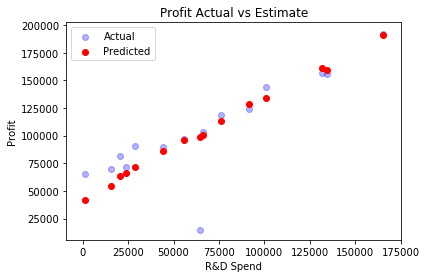

In [22]:
X_test_inv = scaler.inverse_transform(X_test)
plt.scatter(X_test_inv[:, 0], y_test, alpha = 0.3, c = "blue", label = "Actual")
plt.scatter(X_test_inv[:, 0], y_test_pred, c = "red", label = "Predicted")

plt.xlabel("R&D Spend")
plt.ylabel("Profit")
plt.title("Profit Actual vs Estimate")
plt.legend()

In [23]:
np.mean((y_test_pred - y_test) ** 2)

579577930.69277871

In [24]:
y_train_pred = lr.predict(X_train)

Compare the root mean squared error (RMSE) of test dataset against the training.

In [25]:
sqrt(mean_squared_error(y_test, y_test_pred)), sqrt(mean_squared_error(y_train, y_train_pred))

(24074.424825793423, 12413.672826747377)

r2 score can have a max value 1, negative values of R2 means suboptimal model 

In [26]:
r2_score(y_test, y_test_pred), r2_score(y_train, y_train_pred)

(0.69192474547582505, 0.89284947669793391)

On the training the both RMSE and R2 scores perform natually better than those on the test dataset.

# Power Plant Dataset
Let's look at another dataset

In [27]:
df = pd.read_csv("data/Combined_Cycle_Power_Plant.csv")
df.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


In [28]:
X = df.iloc[:, 0:4].values
y = df.PE.values

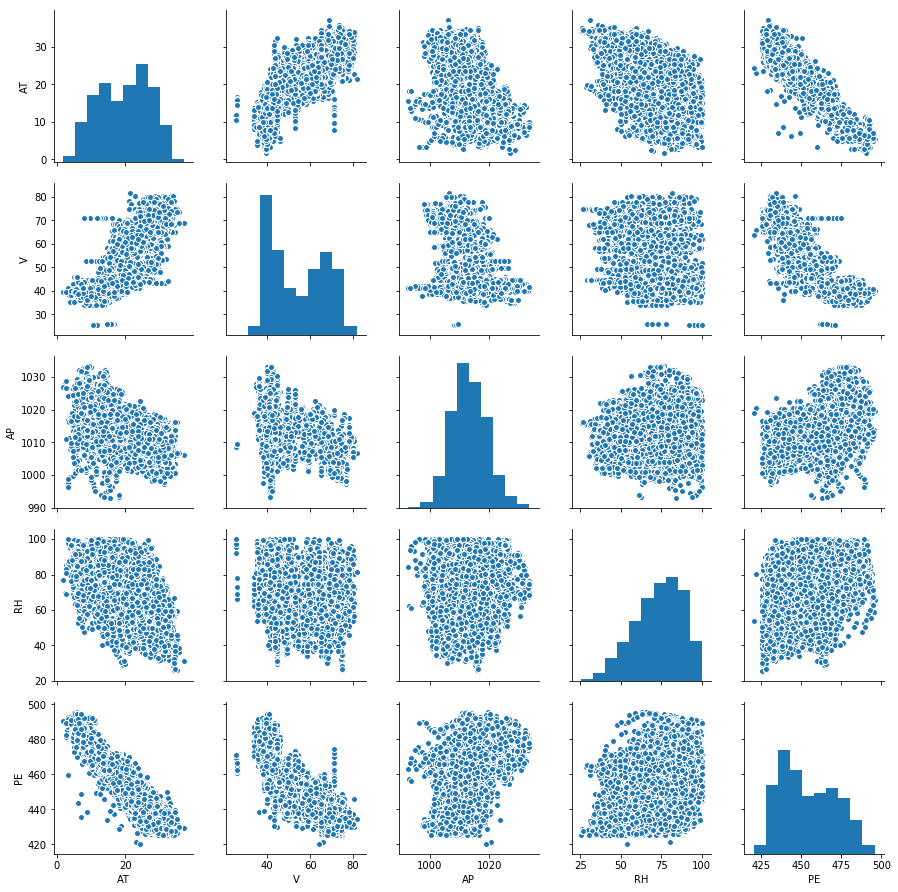

In [29]:
sns.pairplot(df)

In [30]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size = 0.3, random_state = 100)

In [32]:
def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

In [33]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
rmse(y_test, y_test_pred)

4.574907794113806

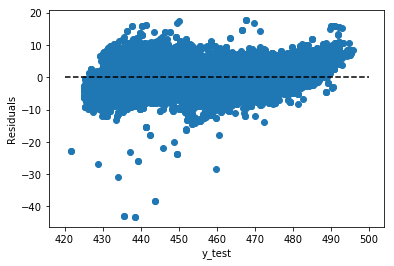

In [34]:
plt.scatter(y_test, y_test - y_test_pred)
plt.xlabel("y_test")
plt.ylabel("Residuals")
plt.hlines([0], xmin = 420, xmax = 500, linestyles = "dashed")

In [35]:
poly = PolynomialFeatures(degree=3)

X = df.iloc[:, 0:4].values
X_poly = poly.fit_transform(X)
X_poly_train, X_poly_test, y_train, y_test = train_test_split(X_poly, y, test_size = 0.3, random_state = 100)
X_poly_train_std = scaler.fit_transform(X_poly_train)
X_poly_test_std = scaler.transform(X_poly_test)

pd.DataFrame(X_poly_train_std).head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,0.0,-0.922813,-1.038771,1.548754,0.887904,-0.961410,-0.981797,-0.911073,-0.588861,-1.003315,...,-0.959993,-0.996290,-0.744974,-0.995997,-0.330714,0.092560,1.554567,0.988064,0.929654,0.883414
1,0.0,0.806093,-0.641344,-0.375735,-1.079505,0.747957,0.058652,0.807495,0.199676,-0.692063,...,-0.723770,-0.697320,-0.972211,-0.666662,-1.225141,-1.231088,-0.380177,-1.091228,-1.104698,-1.085633
2,0.0,-0.838247,-0.839664,0.500565,-0.016857,-0.904417,-0.887329,-0.836248,-0.847481,-0.851878,...,-0.848467,-0.850835,-0.810246,-0.832287,-0.697883,-0.538653,0.495404,0.011160,-0.113315,-0.215640
3,0.0,-1.512091,-1.077333,1.134197,-0.278400,-1.282547,-1.273221,-1.512930,-1.687473,-1.031601,...,-0.980077,-1.027863,-1.054465,-1.052105,-1.051062,-0.868939,1.134124,-0.215048,-0.368302,-0.468638
4,0.0,1.232950,1.498469,-0.315068,-0.995069,1.346129,1.527732,1.238003,0.660068,1.602163,...,1.698289,1.607647,0.927655,1.513673,0.368958,-0.360725,-0.319849,-1.004856,-1.034869,-1.031028


In [36]:
lr.fit(X_poly_train_std, y_train)
print("Train rmse: ", rmse(y_train, lr.predict(X_poly_train_std)))
print("Test rmse: ", rmse(y_test, lr.predict(X_poly_test_std)))

Train rmse:  4.141002117424777
Test rmse:  4.172714790148705


In [37]:
print(lr.intercept_, lr.coef_)

454.309651201 [    -0.      -8816.7761  -4921.5505 -10996.2612  -5893.3819   -148.1145
    618.1485  16737.8468    465.6885   1255.2345   8497.4945   -307.2647
  21410.1096  11093.246     750.1992      5.5246     28.9278    144.8246
    -16.909     -67.6454   -605.072      46.933   -7955.1848   -447.8311
    -16.5434     64.0672  -1303.9081    -30.2703  -3565.0671    296.1907
     13.4979 -10442.8945  -5214.6042   -727.2588    -12.7398]


Polynomial regression generally sufferes from overfitting. Let's regularize the model using Lasso.

In [38]:
lasso = Lasso(alpha=0.03, max_iter=10000, normalize=False, random_state=100)
lasso.fit(X_poly_train_std, y_train)
print("Train rmse: ", rmse(y_train, lasso.predict(X_poly_train_std)))
print("Test rmse: ", rmse(y_test, lasso.predict(X_poly_test_std)))
print(lasso.intercept_, lasso.coef_)

Train rmse:  4.296030842587284
Test rmse:  4.322602672498833
454.309651218 [  0.     -16.5405  -2.6669   0.4665   0.      -0.      -0.      -0.      -0.
  -0.      -0.      -0.       0.       0.       0.       3.348    0.      -0.
   0.       0.      -0.      -0.      -0.      -0.      -0.7131  -0.      -0.
  -0.      -0.      -0.      -1.1925   0.       0.       0.      -0.    ]


Let's find cross validation score that accuracy score is more reliable in a sense that it incorporates every piece of is incorporated in both training and testing.

In [39]:
X_poly_std = scaler.fit_transform(X_poly)
lasso = Lasso(alpha=0.03, max_iter=10000, random_state=100)
scores = cross_val_score(lasso, X_poly_std, y, cv = 10, scoring="neg_mean_squared_error")
scores = np.sqrt(-scores)
print("RMSE scores", scores)
print("Mean rmse: ", np.mean(scores))

RMSE scores [ 4.2757  4.3334  4.3195  4.2904  4.3189  4.2944  4.3783  4.2299  4.337
  4.2716]
Mean rmse:  4.30492116557


LassoCV helps find the best alpha. We could also use model tuning techqniues to find best alpha as well.

In [40]:
# Find best alpha
lassocv = LassoCV(cv = 10, max_iter=10000, tol=1e-5)
lassocv.fit(X_poly_std, y)
print("Lassocv alpha: ", lassocv.alpha_)

# Apply the best alpha to find cross validation score
lasso = Lasso(alpha = lassocv.alpha_, max_iter=10000, random_state=100)
scores = cross_val_score(lasso, X_poly_std, y, cv = 10, scoring="neg_mean_squared_error")
print("Mean rmse: ", np.mean(np.sqrt(-scores)))

Lassocv alpha:  0.0161806999848
Mean rmse:  4.29924666914


Look at the cofficients values. Many of the features are not zero making the model parsimonious hence more robust - that is less prone to overfitting.

Let's plot how coefficient reached 0 values by varying the alpha valuess.

/Users/abulbasar/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


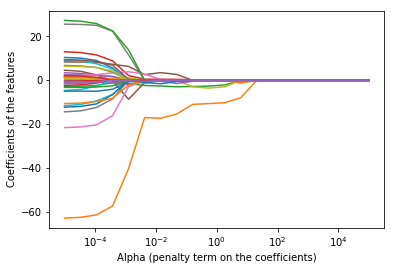

In [41]:
coefs = []
alphas = 10 ** np.linspace(-5, 5, 20)
for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000, tol=1e-5,random_state=100)
    lasso.fit(X_poly_std, y)
    coefs.append(lasso.coef_)

plt.plot(alphas, coefs)
plt.xscale("log")
plt.xlabel("Alpha (penalty term on the coefficients)")
plt.ylabel("Coefficients of the features")
    

From this graph, which alpha values should we select. That question can be answered by looking which alpha values gives the best performance (rmse for example). lassocv function does that for us, or we can use model tuning techniques using grid search - that will be explained later.

### Xgboost


In [42]:
gbm = xgb.XGBRegressor(max_depth=10, learning_rate=0.1, n_estimators=100, 
                     objective='reg:linear', booster='gbtree', 
                     reg_alpha=0.01, reg_lambda=1, random_state=0)
gbm.fit(X_poly_train_std, y_train)
print("rmse:", rmse(y_test, gbm.predict(X_poly_test_std)))

rmse: 1.7980727251265576


rmse: 1.9267087981308941


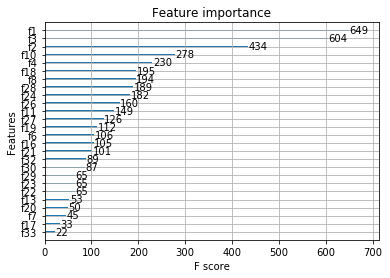

In [43]:
# change booster to gblinear, so that we are fitting a linear model
# alpha is the L1 regularizer
# lambda is the L2 regularizer
# you can also set lambda_bias which is L2 regularizer on the bias term
param = {'silent':1, 
         'objective':'reg:linear', 
         'booster':'gbtree',
         'alpha': 0.01, 
         'lambda': 1
        }

dtrain = xgb.DMatrix(X_poly_train_std, label=y_train)
dtest = xgb.DMatrix(X_poly_test_std, label=y_test)
watchlist  = [(dtrain,'eval'), (dtest, 'train')]
num_round = 100
bst = xgb.train(param, dtrain, num_round, watchlist, verbose_eval=False)
print("rmse:", rmse(y_test, bst.predict(dtest)))
xgb.plot_importance(bst)